In [6]:
## For code syntax related to Keras version used in this code :
# Refer https://insight.io/github.com/fchollet/keras/blob/1.2.1/keras/layers/normalization.py 

from imutils import face_utils
import numpy as np
import imutils
import argparse
import dlib
import cv2
import random
from PIL import Image
# import the necessary packages
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import dlib
import cv2
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
from skimage.feature import hog

%matplotlib inline

save_align_images = 0 
choose_path_delimiter = 0


# linux = 1
# windows = 0
if choose_path_delimiter == 1:
    path_delimiter = '/'
else:
    path_delimiter ='\\'

## Face Align function to align any facial image and crop the face region

In [7]:
#%matplotlib inline
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=256)

# Face Align Function
def faceAlign(image):
    #image = mpimg.imread(img)
    image = imutils.resize(image, width=800)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 2)
    faceAligned = []
    for rect in rects:
        faceAligned = fa.align(image, gray, rect)
        #print(rect)
        #plt.imshow(faceAligned)
    
    return faceAligned


image = mpimg.imread('dataset_cropped/Denise Richards/DeniseRichards471.jpg')
#plt.imshow(image)
#plt.imshow(faceAlign(image))

image = faceAlign(image)


##  Sample Image used for the shape

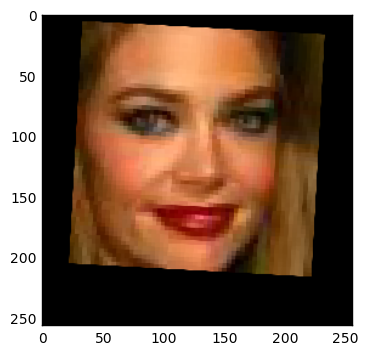

In [8]:
image = mpimg.imread('dataset_cropped/Denise Richards/DeniseRichards471.jpg')

image = faceAlign(image)
plt.imshow(image)

## Function to list files in directories and subdirectories
 Used for listing all  images in a folder 

In [9]:
import os                                                                                                             

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r  
image_paths=list_files('dataset_cropped')

## Label encoder to convert label strings to numbers

In [10]:
# Finding unique labesl and encoding them


all_labels = [imag.split(path_delimiter)[-2] for imag in image_paths]

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_labels)
labels_enc = le.transform(all_labels)

In [11]:
unique_labels = list(le.classes_)
print(unique_labels)
print(le.transform(unique_labels))

['Abhishek Bachan', 'Alex Rodriguez', 'Ali Landry', 'Alyssa Milano', 'Anderson Cooper', 'Anna Paquin', 'Audrey Tautou', 'Barack Obama', 'Ben Stiller', 'Christina Ricci', 'Clive Owen', 'Cristiano Ronaldo', 'Daniel Craig', 'Danny Devito', 'David Duchovny', 'Denise Richards', 'Diane Sawyer']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


## Aligning images and saving them in 'dataset_aligned' folder

In [12]:
if save_align_images == 1:
# Saving Aligned faces to see if keras is faster
    for img_path in image_paths:
        try:
            image = faceAlign(mpimg.imread(img_path));
        except:
            continue
        folder = img_path.split(path_delimiter)[-2]
        filename = img_path.split(path_delimiter)[-1]

        if image is not None and np.shape(np.shape(image)) == (3, ):
            if not os.path.exists('dataset_aligned/'+folder): os.makedirs('dataset_aligned/'+folder)
            cv2.imwrite(("dataset_aligned/{}/{}.jpg".format(folder,filename)),image)    

## Function to read aligned images and append the image as well as the label

In [104]:
def augment_brightness_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .6+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [105]:
# read_images fnc for data_aligned images folder
def read_images_align(image_paths , mod_algo = 0):
    images = [];
    labels = [];
    for img_path in image_paths:
        image = mpimg.imread(img_path)
        images.append(image)
        labels.append(img_path.split(path_delimiter)[1])
    
    if mod_algo:
        #print(len(images))
        #print(np.array(images).shape)
        sz_img = np.array(images).shape[0]
        ind = (np.random.choice(sz_img, int(sz_img/3), replace=False)).astype(int)
        for n in ind:
            images[n] = augment_brightness_images(images[n])
    
    return images,labels

## Function to read as well as align. 
 Makes the CNN model slow as a result

In [ ]:
# for data_cropped folder

from tqdm import tqdm

def read_images(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        try:
            image = faceAlign(mpimg.imread(img_path));
        except:
            continue
        if image is not None and np.shape(np.shape(image)) == (3, ):
            images.append(image)
            labels.append(img_path.split(path_delimiter)[1])
    return images,labels


sample_length = 15
image_paths=list_files('dataset_cropped')
sample_dt=random.sample(image_paths,int(sample_length))
images,labels=read_images(sample_dt)

## Data generator function for CNN

(1, 150, 150)
(150, 150)
[11]


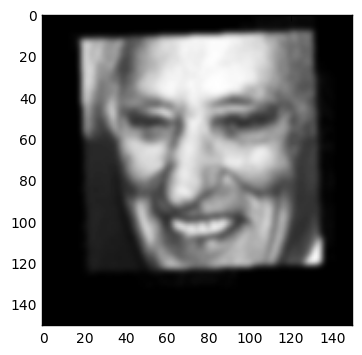

In [106]:
def data_gen(batch_size=30, read_aligned = 1):
    while True:
        
        output_img_sz = 150
        
        image_paths=list_files('dataset_aligned')
        sample_dt=random.sample(image_paths,int(batch_size)+10)
        #print('step1')
        
        if read_aligned ==1:
            images,labels = read_images_align(sample_dt,1)
        else:
            images,labels = read_images(sample_dt)
        images=np.asarray(images)
        labels=np.asarray(labels)
        
        flipped_img=[];
        blur_grays = [];
        for image in images:
            gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
            gray = cv2.equalizeHist(gray)
            gray = cv2.resize(gray, (output_img_sz, output_img_sz)) 
            kernel_size = 7 # Must be an odd number (3, 5, 7...)
            blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
            blur_grays.append(blur_gray)
            flipped_img.append(np.fliplr(blur_gray))
        
        blur_grays = np.append(blur_grays , flipped_img, axis = 0)
        labels = np.append(labels, labels , axis=0)
        #print(np.shape(blur_grays))
        #print(np.shape(labels))
        
        ind = np.random.choice(blur_grays.shape[0], batch_size, replace=False)
        blur_grays=blur_grays[ind,:,:]
        labels=le.transform(labels[ind])
        blur_grays = blur_grays.astype('float32')
    
        blur_grays /= 255.
        
        blur_grays = np.reshape(blur_grays, [-1,1,output_img_sz,output_img_sz])
        X=blur_grays
        y=labels        
        
        #print(np.shape(blur_grays),np.shape(flipped_img))
        y = np.reshape(y, [ -1,1])
        
        yield X,y
        
## Sample of processing images

sample_images,sample_labels = next(data_gen(50,1))
np.shape(sample_images)

sample_choice = random.randint(0,9)
sample_img = sample_images[sample_choice]
print(np.shape(sample_img))
sample_img = np.reshape(sample_img,[np.shape(sample_img)[2],np.shape(sample_img)[2]])
print(np.shape(sample_img))
plt.imshow(sample_img, cmap = 'gray')
print(sample_labels[sample_choice])


## Image Feature Exploration

### Color Exploration

In [ ]:
fig = plt.figure(figsize=[20,10])
plt.subplot(241)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY),cmap='gray')

plt.subplot(242)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_RGB2LUV))

plt.subplot(243)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_RGB2HLS))

plt.subplot(244)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2YCrCb))

### HOG Feature Exploration

In [ ]:



gray = cv2.cvtColor(sample_img,cv2.COLOR_RGB2GRAY)
gray = cv2.equalizeHist(gray)
kernel_size = 7 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 1
high_threshold = 20
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


features , hog_img = hog(gray, orientations=9, 
    pixels_per_cell=(9, 9),
    cells_per_block=(5, 5), 
    transform_sqrt=False, 
    visualise=True, feature_vector=True)



fig = plt.figure(figsize=[20,10])
plt.subplot(251)
plt.imshow(hog_img, cmap =  'gray')

plt.subplot(252)
plt.imshow(edges, cmap = 'Greys_r')

plt.subplot(253)
plt.imshow(gray<60, cmap = 'gray')

plt.subplot(254)
plt.imshow(gray, cmap = 'gray')


img2 = np.zeros_like(sample_img)
img2[:,:,0] = edges
img2[:,:,1] = hog_img
img2[:,:,2] = gray

plt.subplot(255)
plt.imshow(img2)

# note to self ... use equalizeHist function for grayscale images

In [ ]:
# Function to create a feature image and feed to CNN

def process_img(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    
    kernel_size = 7 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    low_threshold = 1
    high_threshold = 20
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    features , hog_img = hog(gray, orientations=9, 
    pixels_per_cell=(9, 9),
    cells_per_block=(7,7), 
    transform_sqrt=False, 
    visualise=True, feature_vector=True)
    
    img2 = np.zeros_like(sample_img)
    img2[:,:,0] = edges
    img2[:,:,1] = hog_img
    img2[:,:,2] = gray
    
    return img2

## Base CNN model to train and test 

In [ ]:
# CNN Base Version 1

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


input_shape=(1, sample_img.shape[0],sample_img.shape[1])

model_base = Sequential()

model_base.add(Conv2D(32, 3, 3, input_shape=input_shape, dim_ordering='th'))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))

model_base.add(Conv2D(32, 3, 3,dim_ordering='th'))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))

model_base.add(Conv2D(64, 3, 3, dim_ordering='th'))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))


model_base.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_base.add(Dense(64))
model_base.add(Activation('relu'))
model_base.add(Dropout(0.5))
model_base.add(Dense(17))
model_base.add(Activation('sigmoid'))

model_base.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)

model_base.summary()
model_base.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

In [ ]:
from keras.models import load_model
model_base = load_model('modelV2.h5')
batch_size=30
epochs=50
gen_train=data_gen(30)
gen_valid=data_gen(30)

model_base.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

In [ ]:
# Saving the weights
#model_base.save('modelV3.h5')

## Testing the model
### Testing from the database

In [ ]:
from keras.models import load_model
model_base = load_model('modelV3.h5')
test_images,test_labels = next(data_gen(5,0))

In [ ]:
num_images = np.shape(test_images)[0]

plt.figure(figsize=[20,20])


for n_img in range(0,num_images):
    test_img = test_images[n_img]
    test_img_exp = np.reshape(test_img,[150,150])
    ax = plt.subplot(1,num_images,n_img+1)
    plt.imshow(test_img_exp, cmap = 'gray')
    ax.set_title(test_labels[n_img])

#test_img = test_images[0]
#test_img_exp = np.reshape(test_img,[150,150])
#print(np.shape(test_img_exp))
#plt.imshow(test_img_exp, cmap = 'gray')
#print(test_labels[0])

In [ ]:
from sklearn.metrics import f1_score
#test_img = np.reshape(test_img , [-1,1,150,150])
preds = model_base.predict(test_images)

#print(f1_score(test_labels, prediction, average='macro'))
print(np.argmax(preds, axis = 1))


### Testing on a web image

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

## Reading the image
img = []
img_path = 'test_images\\Anna Paquin\\anna_paquin.jpg'
img_label = img_path.split(path_delimiter)[-2]
enc_img_label = le.transform([img_label])

img = mpimg.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


## Detecting faces and cropping
faces = face_cascade.detectMultiScale(gray, 1.3, 2)
if faces.size:
    for (x,y,w,h) in faces:
        #print(x,y,w,h)
        cropped_img =  img[y:y+h, x:x+w]
else:
    print('Face not found')
    
## Aligning the image
aligned_img = faceAlign(cropped_img)
aligned_img=np.asarray(aligned_img)


## Preprocessing the image for the model
gray = cv2.cvtColor(aligned_img,cv2.COLOR_RGB2GRAY)
gray = cv2.equalizeHist(gray)
gray = cv2.resize(gray, (150, 150)) 
kernel_size = 7 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

blur_gray = blur_gray.astype('float32')

blur_gray /= 255.

blur_gray = np.reshape(blur_gray, [-1,1,150,150])

test_img = blur_gray


## Plotting the image
test_img_exp = np.reshape(test_img,[150,150])
plt.imshow(test_img_exp, cmap = 'gray')
plt.title(str(enc_img_label)+' - '+img_label)

In [ ]:
# Predicted Value
preds = model_base.predict(test_img)
enc_label = np.argmax(preds, axis = 1)
label = le.inverse_transform(enc_label)

print(str(enc_label),' - ',label)


## Alexnet Model

In [16]:
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import ZeroPadding2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense



def AlexNet(sample_img):
    input_shape = (1, sample_img.shape[0],sample_img.shape[1])
    print(input_shape)
    model_alex = Sequential()
    
    #model_alex.add(Lambda(lambda x:x/255.0-0.50,input_shape=input_shape))
    model_alex.add(Conv2D(96, 11, 11, input_shape=input_shape, dim_ordering='th', border_mode='same', activation='relu', name='conv_1'))
    #model_alex.add(Activation('relu', name='actv_1'))
    model_alex.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2) ,dim_ordering='th', name="maxpool_1"))
    model_alex.add(BatchNormalization())
    print('before zero padding')
    #model_alex.add(ZeroPadding2D((2, 2)))
    
    model_alex.add(Conv2D(128 ,5 ,5 ,dim_ordering='th', border_mode='same', activation='relu', name='conv_2'))
    #model_alex.add(Activation('relu', name='actv_2'))
    model_alex.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2) ,dim_ordering='th', name='maxpool_2'))
    model_alex.add(BatchNormalization())
    #model_alex.add(ZeroPadding2D((1, 1)))    
    
    model_alex.add(Conv2D(384 ,3 ,3 , dim_ordering='th' , border_mode='same', activation='relu', name='conv_3'))
    #model_alex.add(Activation('relu', name='actv_3'))
    #model_alex.add(ZeroPadding2D(padding=(1, 1))) 
    
    model_alex.add(Conv2D(192 ,3 ,3 , dim_ordering='th' , border_mode='same', activation='relu', name='conv_4'))
    #model_alex.add(Activation('relu', name='actv_4'))
    #model_alex.add(ZeroPadding2D(padding=(1, 1))) 
    
    model_alex.add(Conv2D(128 ,3 ,3 , dim_ordering='th' , activation='relu', name='conv_5'))
    #model_alex.add(Activation('relu', name='actv_5'))
    model_alex.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2) ,dim_ordering='th', name='maxpool_5'))
    
    model_alex.add(Flatten(name='flatten'))  
    model_alex.add(Dense(4096, name='dense_1', activation='relu'))
    #model_alex.add(Activation('relu'))
    model_alex.add(Dropout(0.5))
  
    model_alex.add(Dense(4096, name='dense_2', activation='relu'))
    #model_alex.add(Activation('relu'))
    model_alex.add(Dropout(0.5))
    
    model_alex.add(Dense(17,  name='dense_3'))
    model_alex.add(Activation('sigmoid'))
    print('done')
    return model_alex


Using TensorFlow backend.


In [11]:

model_alex = AlexNet(sample_img)

model_alex.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#batch_size=30

epochs = 30
samp_per_epoch=200
gen_train=data_gen(2, 1)
gen_valid=data_gen(2, 1)


model_alex.summary()
model_alex.fit_generator(gen_train, samples_per_epoch=samp_per_epoch, nb_epoch=epochs, validation_data=gen_valid ,nb_val_samples=25, max_q_size=25)

(1, 110, 110)
before zero padding
done
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv_1 (Convolution2D)           (None, 96, 110, 110)  11712       convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)         (None, 96, 54, 54)    0           conv_1[0][0]                     
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 96, 54, 54)    216         maxpool_1[0][0]                  
____________________________________________________________________________________________________
conv_2 (Convolution2D)           (None, 128, 54, 54)   307328      batchnormalization_1[0][0]       
____________________________________________________

### Issues encountered with Alexnet
* Computing power required for training alexnet seems to be very high
* Images had to be rescaled to a smaller dimension thus losing out on a lot of facial features
* Batch of data sent to the generator had to be restricted to 2 so as to get the alexnet to start training


### Modified CNN model

In [158]:
# CNN Base Version 1

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

def model_CNNMod(sample_img):
    input_shape=(1, sample_img.shape[0],sample_img.shape[1])

    model_mod = Sequential()

    model_mod.add(Conv2D(32, 3, 3, input_shape=input_shape, border_mode="valid", dim_ordering='th' ,activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    model_mod.add(BatchNormalization())
    
    model_mod.add(Conv2D(32, 3, 3,dim_ordering='th', border_mode="same", activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    model_mod.add(BatchNormalization())
    
    model_mod.add(Conv2D(64, 3, 3,dim_ordering='th', activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    #model_mod.add(Dropout(0.3))
    
    model_mod.add(Conv2D(128, 3, 3, dim_ordering='th', activation='relu'))
    model_mod.add(MaxPooling2D(pool_size=(2, 2),dim_ordering='th'))
    
    model_mod.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model_mod.add(Dense(500,  activation='relu'))
    model_mod.add(Dropout(0.5))
    model_mod.add(Dense(300,  activation='relu'))
    model_mod.add(Dense(64,  activation='relu'))
    model_mod.add(Dropout(0.5))
    #model_mod.add(Dense(17))
    #model_mod.add(Dropout(0.1))
    model_mod.add(Dense(17))
    model_mod.add(Activation('sigmoid'))

    return model_mod

model_mod = model_CNNMod(sample_img)
model_mod.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model_mod.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_77 (Convolution2D) (None, 32, 148, 148)  320         convolution2d_input_23[0][0]     
____________________________________________________________________________________________________
maxpooling2d_77 (MaxPooling2D)   (None, 32, 74, 74)    0           convolution2d_77[0][0]           
____________________________________________________________________________________________________
batchnormalization_33 (BatchNorm (None, 32, 74, 74)    296         maxpooling2d_77[0][0]            
____________________________________________________________________________________________________
convolution2d_78 (Convolution2D) (None, 32, 74, 74)    9248        batchnormalization_33[0][0]      
___________________________________________________________________________________________

In [159]:
from math import ceil
from keras_tqdm import TQDMNotebookCallback
batch_size=30
epochs=50
samp_per_epoch=1000

samp_per_epoch = batch_size * ceil(samp_per_epoch/batch_size)

gen_train=data_gen(batch_size)
gen_valid=data_gen(batch_size)


model_mod.fit_generator(gen_train, samples_per_epoch = samp_per_epoch,nb_epoch=epochs,
                        validation_data=gen_valid,nb_val_samples=25, max_q_size=25 ,
                       verbose=0, callbacks=[TQDMNotebookCallback(leave_inner =True)])

model_mod.save('model_CNNModV1.h5')

### Modified ALEXNET Model

In [ ]:
# Modified Alexnet

from keras.models import Sequential
from keras.layers import Flatten,Dense, Lambda
# There was a problem with original Keras progress bar due to which Notebook used to hang.
# Changing the progress bar with another version of it so as to get the code working in Notebook. Look at model.fit command on how its used
#from keras_tqdm import TQDMNotebookCallback 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D, ELU
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

input_shape=(sample_img.shape[0],sample_img.shape[1],1)
model=Sequential()
#model.add(Lambda(lambda x:x/255.0-0.50,input_shape=input_shape))
model.add(Conv2D(3,1,1,subsample=(1,1),border_mode="valid",init='he_normal',input_shape=input_shape))
model.add(ELU())
model.add(Conv2D(24,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(36,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Dropout(.4))
model.add(Conv2D(48,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(Dropout(.3))
model.add(ELU())
model.add(Flatten())
model.add(Dense(1164,init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(100,init='he_normal'))
model.add(ELU())
model.add(Dense(50,init='he_normal'))
model.add(ELU())
model.add(Dense(10,init='he_normal'))
model.add(ELU())
model.add(Dense(17,init='he_normal'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(15)
gen_valid=data_gen(15)


model.fit_generator(gen_train, samples_per_epoch=2500,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25, verbose =2)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)

model.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

In [ ]:
model = Sequential()  

# first set of CONV => RELU => POOL  
model.add(Conv2D(20, 5, 5, border_mode="same",  
         input_shape=input_shape))  
model.add(Activation("relu"))  
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  

# second set of CONV => RELU => POOL  
model.add(Conv2D(50, 5, 5, border_mode="same"))  
model.add(Activation("relu"))  
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  

# set of FC => RELU layers  
model.add(Flatten())  
model.add(Dense(500))  
model.add(Activation("relu"))  

# softmax classifier  
model.add(Dense(17))  
model.add(Activation("softmax"))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)


model.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

In [ ]:
## New Iteration of CNN https://martinbel.github.io/face-detection.html

from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.pooling import AveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras import optimizers 
from keras.callbacks import ModelCheckpoint, History, Callback
from keras.layers.advanced_activations import PReLU
from keras import initializations
from keras.models import load_model
from keras.optimizers import *

def conv_3x3_2fc_500(size):
    model = Sequential()
    init = 'he_normal'
    # Block 1
    model.add(Convolution2D(64, 5, 5, activation='relu', border_mode='valid', name='block1_conv1', 
                            init=init, input_shape=(1, size, size), subsample=(1, 1) ,dim_ordering="th"))
#    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2', init=init))
    model.add(MaxPooling2D((5, 5), strides=(2, 2), name='block1_pool',border_mode='valid', dim_ordering='th'))

    model.add(Convolution2D(128, 5, 5, activation='relu', border_mode='valid', name='block2_conv1', init=init ,dim_ordering="th"))
#    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2', init=init))
    model.add(MaxPooling2D((5, 5), strides=(2, 2),  name='block2_pool',border_mode='valid', dim_ordering='th'))

    model.add(Convolution2D(256, 3, 3, activation='relu', border_mode='valid', name='block3_conv1', init=init ,dim_ordering="th"))
#    model.add(Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2', init=init))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name='block3_pool',border_mode='valid', dim_ordering='th'))

    model.add(Convolution2D(512, 3, 3, activation='relu', border_mode='valid', name='block4_conv1', init=init ,dim_ordering="th"))
#    model.add(Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2', init=init))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name='block4_pool',border_mode='valid', dim_ordering='th'))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu', init='he_normal', name='fc1'))
    model.add(Dropout(p=0.5))
    model.add(Dense(500, activation='relu', init='he_normal', name='fc2'))
    model.add(Dropout(p=0.5))
#    model.add(AveragePooling2D(pool_size=(8, 8), strides=None, border_mode='valid', dim_ordering='th'))
    #model.add(Dropout(p=0.5))
    model.add(Dense(17, activation='softmax', name='predictions'))
    
    optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optim = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [ ]:
batch_size=30
epochs=100
gen_train=data_gen(30)
gen_valid=data_gen(30)


model = conv_3x3_2fc_500(size=150)
model.summary()

#loss_history = History()
#model.optimizer.lr.assign(0.001)
model.fit_generator(gen_train, samples_per_epoch=500,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)